In [1]:
import csv
import pandas as pd
from datetime import datetime
from Levenshtein import distance as levenshtein_distance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
from fitter import Fitter
import itertools
import multiprocessing
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression

In [2]:
events_final = pd.read_csv('truncated_events_final_oneday.csv') 
print(events_final)

       patientid                                    events  \
0       10002013                                     CSURG   
1       10002013                                       ABG   
2       10002013                                   Calcium   
3       10002013                                   Glucose   
4       10002013                                       CBC   
...          ...                                       ...   
59156   19995790  Chlorhexidine Gluconate 0.12% Oral Rinse   
59157   19995790                                Ranitidine   
59158   19995790                           Docusate Sodium   
59159   19995790                                       CBC   
59160   19995790                              Electrolytes   

                 starttime  
0      2160-05-18 01:49:32  
1      2160-05-18 09:19:00  
2      2160-05-18 09:19:00  
3      2160-05-18 09:19:00  
4      2160-05-18 09:19:00  
...                    ...  
59156  2185-02-02 20:00:00  
59157  2185-02-02 20:00

In [3]:

events_final['starttime'] = pd.to_datetime(events_final['starttime'])

In the next step, we will start to generat the trace

In [4]:

traces = events_final.groupby('patientid')['events'].apply(list).reset_index()
traces['starttimes'] = events_final.groupby('patientid')['starttime'].apply(list).reset_index(drop=True)

In [5]:
print(traces.head())
traces.to_csv('traces.csv', index=False)

   patientid                                             events  \
0   10002013  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   
1   10011398  [CSURG, ABG, Electrolytes, CBC, Glucose, Calci...   
2   10023771  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   
3   10033786  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   
4   10039688  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   

                                          starttimes  
0  [2160-05-18 01:49:32, 2160-05-18 09:19:00, 216...  
1  [2146-12-15 04:53:55, 2146-12-15 07:52:00, 214...  
2  [2113-08-25 03:17:43, 2113-08-25 07:29:00, 211...  
3  [2118-01-16 06:35:16, 2118-01-16 12:00:00, 211...  
4  [2147-05-31 02:31:44, 2147-05-31 07:57:00, 214...  


In [6]:
print(traces['events'].dtype)

object


In [7]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])

['CSURG', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'Electrolytes', 'ABG', 'CBC', 'Glucose', 'Aspirin', 'ABG', 'Glucose', 'CBC', 'Electrolytes', 'Acetaminophen', 'Nitroglycerin', 'Sterile Water', 'Neostigmine', 'Opioid', 'Influenza Vaccine', 'Potassium Chloride', 'Dextrose 50%', 'Magnesium Sulfate', 'PHENYLEPHrine', 'Milk of Magnesia', 'Sodium Chloride 0.9%  Flush', 'Oxycodone-Acetaminophen', '5% Dextrose', 'Pneumococcal Vaccine', 'Glycopyrrolate', 'Metoclopramide', 'Insulin', 'Propofol', 'Sodium Chloride 0.9%', 'Calcium Gluconate', 'Lactated Ringers', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'CBC', 'Sodium Chloride 0.9%', 'CefazoLIN', 'CBC', 'Urea Nitrogen', 'Electrolytes', 'Creatinine', 'Bicarbonate', 'ABG', 'Calcium', 'Glucose', 'Electrolytes', 'ABG', 'Electrolytes', 'Calcium', 'Glucose', 'Ketorolac', 'ABG', 'Glucose', 'Electrolytes', 'Electrolytes', 'CBC', 'Ondansetron', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Albumin', 'Li

In [8]:
def calculate_hamming_distance(list1, list2, pad_value=None):
    # Pad the shorter list
    max_len = max(len(list1), len(list2))
    list1_padded = list1 + [pad_value] * (max_len - len(list1))
    list2_padded = list2 + [pad_value] * (max_len - len(list2))
    
  
    distance = sum(el1 != el2 for el1, el2 in zip(list1_padded, list2_padded))
    return distance

In [9]:

list1 = ['A','B','C','D']
list2 =['A','C','D']


hamming_distance_example = calculate_hamming_distance(list1, list2, pad_value='')
print(f"Hamming distance between list1 and list2: {hamming_distance_example}")

levenshtein_distance_example = levenshtein_distance(list1, list2)
print(f"levenshtein distance between list1 and list2: {levenshtein_distance_example}")

Hamming distance between list1 and list2: 3
levenshtein distance between list1 and list2: 1


In [10]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])
print(len(traces.iloc[1]['events']))
print(len(traces.iloc[2]['events']))
hamming_distance_1_2 = calculate_hamming_distance(first_line, second_line)
levenshtein_distance_1_2 = levenshtein_distance(first_line, second_line)
print(f"Hamming distance between the first and second lines: {hamming_distance_1_2}")
print(f"Levenshtein distance between the first and second lines: {levenshtein_distance_1_2}")

['CSURG', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'Electrolytes', 'ABG', 'CBC', 'Glucose', 'Aspirin', 'ABG', 'Glucose', 'CBC', 'Electrolytes', 'Acetaminophen', 'Nitroglycerin', 'Sterile Water', 'Neostigmine', 'Opioid', 'Influenza Vaccine', 'Potassium Chloride', 'Dextrose 50%', 'Magnesium Sulfate', 'PHENYLEPHrine', 'Milk of Magnesia', 'Sodium Chloride 0.9%  Flush', 'Oxycodone-Acetaminophen', '5% Dextrose', 'Pneumococcal Vaccine', 'Glycopyrrolate', 'Metoclopramide', 'Insulin', 'Propofol', 'Sodium Chloride 0.9%', 'Calcium Gluconate', 'Lactated Ringers', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'CBC', 'Sodium Chloride 0.9%', 'CefazoLIN', 'CBC', 'Urea Nitrogen', 'Electrolytes', 'Creatinine', 'Bicarbonate', 'ABG', 'Calcium', 'Glucose', 'Electrolytes', 'ABG', 'Electrolytes', 'Calcium', 'Glucose', 'Ketorolac', 'ABG', 'Glucose', 'Electrolytes', 'Electrolytes', 'CBC', 'Ondansetron', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Albumin', 'Li

In [11]:
num_elements = len(traces)
hamming_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))


for i in range(num_elements):
    for j in range(num_elements):
        hamming_distance = calculate_hamming_distance(traces.at[i, "events"], traces.at[j, "events"])
        hamming_distance_matrix.at[i, j] = hamming_distance


print(hamming_distance_matrix)

    0   1   2   3   4   5   6   7   8   9    ... 837 838 839 840 841 842 843  \
0     0  70  65  65  68  71  70  75  74  70  ...  66  70  71  70  78  73  72   
1    70   0  70  72  74  68  71  64  72  72  ...  65  67  75  75  77  72  68   
2    65  70   0  64  66  69  75  70  63  59  ...  71  67  68  71  72  69  75   
3    65  72  64   0  58  69  71  63  56  62  ...  73  63  55  77  65  68  72   
4    68  74  66  58   0  71  70  61  64  62  ...  70  61  62  68  66  67  72   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
842  73  72  69  68  67  69  69  63  62  64  ...  70  69  64  73  72   0  70   
843  72  68  75  72  72  67  69  71  67  67  ...  70  73  73  77  78  70   0   
844  76  74  66  62  61  70  70  67  59  56  ...  75  55  56  73  61  68  74   
845  79  79  74  67  65  75  77  69  62  60  ...  78  64  64  81  22  72  78   
846  75  66  70  64  64  68  70  59  59  53  ...  66  56  58  75  61  62  73   

    844 845 846  
0    76  79  75  
1  

In [12]:

hamming_row_averages = hamming_distance_matrix.mean(axis=1)
print("Hamming row averages:")
print(hamming_row_averages)

Hamming row averages:
0      73.584416
1      73.273908
2      70.233766
3      68.146399
4       67.38843
         ...    
842    70.380165
843    73.909091
844    67.029516
845    69.154664
846    66.919717
Length: 847, dtype: object


In [13]:

hamming_sorted_row_averages = hamming_row_averages.sort_values(ascending=False)


hamming_reordered_matrix = hamming_distance_matrix.loc[hamming_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(hamming_sorted_row_averages)

print("Reordered Hamming distance matrix:")
print(hamming_reordered_matrix)

Sorted row averages (descending):
416    124.374262
333    110.539551
79     102.977568
440    101.990555
276    101.021251
          ...    
236      66.33412
336     66.291617
563     66.038961
829     66.034238
627     65.971665
Length: 847, dtype: object
Reordered Hamming distance matrix:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
416  124  122  122  122  123  125  126  124  122  128  ...  118  122  126   
333  103  110  101  108  104  110  109  107  110  112  ...  106  114  110   
79   103  102  103  102  108  103   99  106  103  104  ...  103  105   97   
440  104  101  105  105   98  107   97  101  106  104  ...  102   98  101   
276  100   98  100  102   95  105  102   98  101   99  ...   95   95  102   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
236   71   68   66   63   61   70   71   59   55   56  ...   72   56   60   
336   74   70   64   60   65   74   74   63   52   52  ...   76   60   59   
563   68   71

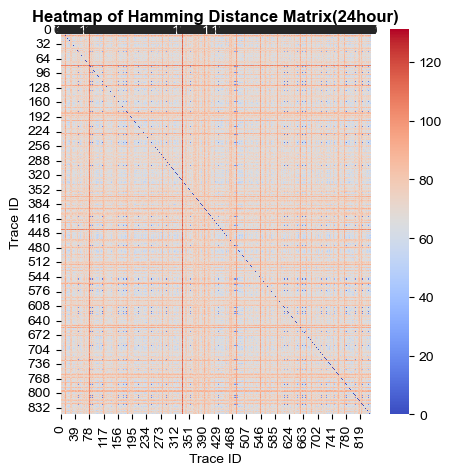

In [54]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Hamming Distance Matrix(24hour)', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure1_Heatmap of Hamming Distance Matrix(24hour).png', format='png', dpi=300)
plt.show()

In [15]:
levenshtein_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))


for i in range(num_elements):
    for j in range(num_elements):
        dist = levenshtein_distance(traces.at[i, "events"], traces.at[j, "events"])
        levenshtein_distance_matrix.at[i, j] = dist


print(levenshtein_distance_matrix)

    0   1   2   3   4   5   6   7   8   9    ... 837 838 839 840 841 842 843  \
0     0  61  54  47  54  59  57  52  54  52  ...  58  56  51  61  70  54  56   
1    61   0  52  53  57  57  62  54  55  51  ...  55  56  57  59  68  55  59   
2    54  52   0  45  47  55  59  41  44  46  ...  55  54  53  56  64  57  56   
3    47  53  45   0  53  54  57  49  45  47  ...  47  52  45  58  57  47  53   
4    54  57  47  53   0  60  62  42  44  48  ...  56  51  56  52  58  58  62   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
842  54  55  57  47  58  53  55  54  51  53  ...  56  57  47  63  62   0  52   
843  56  59  56  53  62  53  53  54  56  56  ...  57  65  52  65  69  52   0   
844  59  54  55  51  49  62  61  47  43  46  ...  55  45  50  58  54  58  64   
845  69  66  62  56  60  67  70  62  53  53  ...  65  56  54  70  12  59  67   
846  53  53  50  44  47  57  57  44  45  41  ...  53  51  49  58  52  54  60   

    844 845 846  
0    59  69  53  
1  

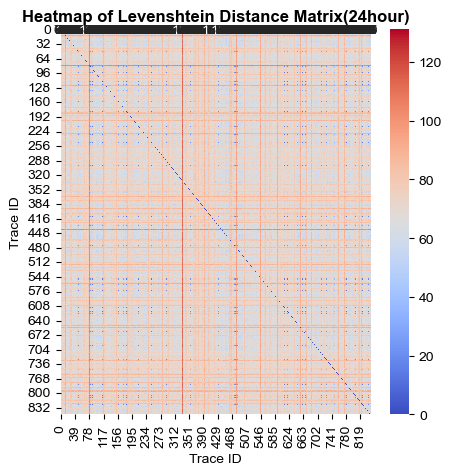

In [55]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Levenshtein Distance Matrix(24hour)', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure2_Heatmap of Levenshtein Distance Matrix(24hour).png', format='png', dpi=300)
plt.show()

In [17]:

levenshtein_row_averages = levenshtein_distance_matrix.mean(axis=1)


print("Levenshtein row averages:")
print(levenshtein_row_averages)

Levenshtein row averages:
0      59.854782
1       58.70366
2      55.938607
3       54.16647
4      54.095632
         ...    
842    58.438017
843    61.716647
844    53.690673
845    60.469894
846    53.268005
Length: 847, dtype: object


In [18]:
levenshtein_averages = levenshtein_row_averages.tolist()
levenshtein_averages = pd.DataFrame(levenshtein_row_averages, columns=['variation distance'])

print("Levenshtein averages:")
print(levenshtein_averages)

Levenshtein averages:
    variation distance
0            59.854782
1             58.70366
2            55.938607
3             54.16647
4            54.095632
..                 ...
842          58.438017
843          61.716647
844          53.690673
845          60.469894
846          53.268005

[847 rows x 1 columns]


In [19]:

levenshtein_sorted_row_averages = levenshtein_row_averages.sort_values(ascending=False)


levenshtein_reordered_matrix = levenshtein_distance_matrix.loc[levenshtein_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(levenshtein_sorted_row_averages)

print("Reordered Levenshtein distance matrix:")
print(levenshtein_reordered_matrix)

Sorted row averages (descending):
416    101.631641
333      87.79693
79      83.710744
276     81.598583
214     79.197166
          ...    
690     51.959858
749     51.854782
8       51.701299
250     51.675325
734     51.149941
Length: 847, dtype: object
Reordered Levenshtein distance matrix:
    0    1   2    3    4   5   6    7    8    9    ... 837  838 839 840  841  \
416  96  100  98  101  103  96  96  100  101  105  ...  96  100  97  99  118   
333  82   87  82   81   87  79  84   83   84   88  ...  81   89  83  85  108   
79   83   81  78   81   86  74  83   80   81   83  ...  85   80  77  86   96   
276  78   82  81   83   77  76  86   77   77   83  ...  78   82  82  74   98   
214  79   72  68   75   76  78  79   77   76   77  ...  76   81  76  77   93   
..   ..  ...  ..  ...  ...  ..  ..  ...  ...  ...  ...  ..  ...  ..  ..  ...   
690  57   54  46   45   45  53  59   40   41   38  ...  54   48  47  57   50   
749  53   55  52   45   44  57  59   43   42   38  ...  52   4

In [20]:
temp_distance = levenshtein_sorted_row_averages.reset_index(drop=True)

top_2_5_percentile = np.percentile(temp_distance, 97.5)
top_5_percentile = np.percentile(temp_distance, 95)
top_10_percentile = np.percentile(temp_distance, 90)
top_20_percentile = np.percentile(temp_distance, 80)
bottom_20_percentile = np.percentile(temp_distance, 20)

print(f"Top 2.5% of the list is above: {top_2_5_percentile}")
print(f"22 th: {levenshtein_sorted_row_averages[21]}")
print(f"Top 5% of the list is above: {top_5_percentile}")
print(f"Top 10% of the list is above: {top_10_percentile}")
print(f"Top 20% of the list is above: {top_20_percentile}")
print(f"Bottom 20% of the list is below: {bottom_20_percentile}")

Top 2.5% of the list is above: 71.0313459268005
22 th: 53.85596221959858
Top 5% of the list is above: 67.01145218417945
Top 10% of the list is above: 64.23541912632822
Top 20% of the list is above: 61.769067296340026
Bottom 20% of the list is below: 55.19669421487603


In [21]:
if not levenshtein_sorted_row_averages.index.equals(hamming_sorted_row_averages.index):
    levenshtein_sorted_row_averages_positions = pd.Series(levenshtein_sorted_row_averages.index, name='levenshtein_sorted_row_averages_index')
    hamming_sorted_row_averages_positions = pd.Series(hamming_sorted_row_averages.index, name='hamming_sorted_row_averages_index')

    comparison_df = pd.DataFrame({'levenshtein_sorted_row_averages_position': levenshtein_sorted_row_averages_positions, 'hamming_sorted_row_averages_position': hamming_sorted_row_averages_positions})
    mismatched_positions = comparison_df[levenshtein_sorted_row_averages_positions != hamming_sorted_row_averages_positions]
    display(comparison_df)  
    print("Mismatched indexes and their positions:")
    display(mismatched_positions)  
else:
    print("Both DataFrames have the same index order.")

,levenshtein_sorted_row_averages_position,hamming_sorted_row_averages_position
0,416,416
1,333,333
2,79,79
3,276,440
4,214,276
...,...,...
842,690,236
843,749,336
844,8,563
845,250,829


Mismatched indexes and their positions:


,levenshtein_sorted_row_averages_position,hamming_sorted_row_averages_position
3,276,440
4,214,276
5,440,214
7,367,480
9,480,373
...,...,...
842,690,236
843,749,336
844,8,563
845,250,829


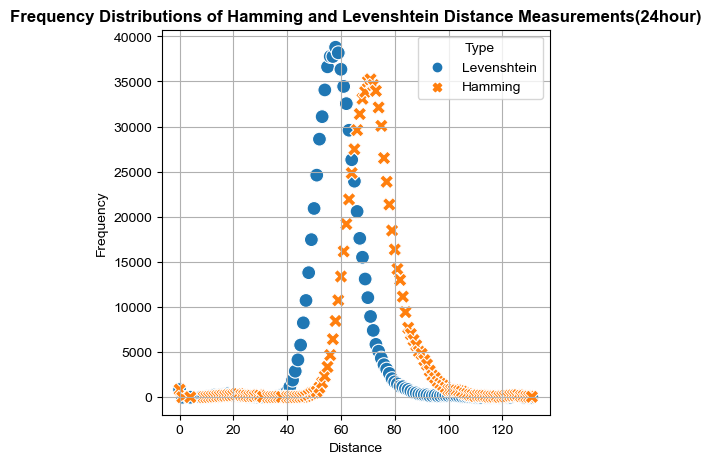

In [56]:
lev_distances = levenshtein_distance_matrix.values.flatten()
ham_distances = hamming_distance_matrix.values.flatten()

lev_unique_distances, lev_counts = np.unique(lev_distances, return_counts=True)
ham_unique_distances, ham_counts = np.unique(ham_distances, return_counts=True)

lev_distance_freq_df = pd.DataFrame({'Distance': lev_unique_distances, 'Frequency': lev_counts, 'Type': 'Levenshtein'})
ham_distance_freq_df = pd.DataFrame({'Distance': ham_unique_distances, 'Frequency': ham_counts, 'Type': 'Hamming'})

distance_freq_df = pd.concat([lev_distance_freq_df, ham_distance_freq_df])


plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=distance_freq_df, x='Distance', y='Frequency', hue='Type', style='Type', s=100)

#plt.title('Frequency Distributions of Hamming and Levenshtein Distance Measurements(24hour)', fontsize=12, fontweight='bold')
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.savefig('eFigure3_Frequency Distributions of Hamming and Levenshtein Distance Measurements(24hour).png', bbox_inches='tight',format='png', dpi=300)
plt.grid(True)
plt.show()

In [23]:
#Select the top 2.5% and bottom 2.5% lists
top_2_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.025))
bottom_2_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.975))

top_2_percent_lists = levenshtein_reordered_matrix.iloc[:top_2_percent_index]
bottom_2_percent_lists = levenshtein_reordered_matrix.iloc[bottom_2_percent_index:]

In [24]:
# Select the top 5% and bottom 5% lists
top_5_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.05))
bottom_5_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.95))

top_5_percent_lists = levenshtein_reordered_matrix.iloc[:top_5_percent_index]
bottom_5_percent_lists = levenshtein_reordered_matrix.iloc[bottom_5_percent_index:]

In [25]:
# Select the top 10% and bottom 10% lists
top_10_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.10))
bottom_10_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.90))

top_10_percent_lists = levenshtein_reordered_matrix.iloc[:top_10_percent_index]
bottom_10_percent_lists = levenshtein_reordered_matrix.iloc[bottom_10_percent_index:]

In [26]:
# Select the top 20% and bottom 20% lists
top_20_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.20))
bottom_20_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.80))

top_20_percent_lists = levenshtein_reordered_matrix.iloc[:top_20_percent_index]
bottom_20_percent_lists = levenshtein_reordered_matrix.iloc[bottom_20_percent_index:]

In [27]:
print("Top 2.5% lists:")
print(top_2_percent_lists)
print("Bottom 2.5% lists:")
print(bottom_2_percent_lists)

top_2_percent_index = top_2_percent_lists.index.tolist()
print("PatientID of Top 2.5% traces:")
print(top_2_percent_lists.index.tolist())
bottom_2_percent_index = bottom_2_percent_lists.index.tolist()
print("PatientID of Bottom 2.5% traces:")
print(bottom_2_percent_lists.index.tolist())

Top 2.5% lists:
    0    1   2    3    4   5   6    7    8    9    ... 837  838 839 840  841  \
416  96  100  98  101  103  96  96  100  101  105  ...  96  100  97  99  118   
333  82   87  82   81   87  79  84   83   84   88  ...  81   89  83  85  108   
79   83   81  78   81   86  74  83   80   81   83  ...  85   80  77  86   96   
276  78   82  81   83   77  76  86   77   77   83  ...  78   82  82  74   98   
214  79   72  68   75   76  78  79   77   76   77  ...  76   81  76  77   93   
440  74   75  73   77   75  78  78   75   75   72  ...  71   76  76  66   98   
460  70   74  74   73   80  67  70   69   71   72  ...  73   75  67  79   95   
367  72   73  73   72   72  70  71   74   73   74  ...  74   75  70  82   85   
804  67   68  67   66   76  73  70   67   70   73  ...  67   73  71  75   91   
480  64   70  67   66   72  70  69   69   69   69  ...  69   76  64  75   93   
373  78   71  71   73   68  79  79   69   68   71  ...  75   65  77  67   88   
592  71   76  71   73   

In [28]:
complete_patients_clinical = pd.read_csv('completepatients.csv')
complete_patients = pd.concat([complete_patients_clinical,levenshtein_averages], axis=1)
print(complete_patients.head())

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  \
0         SINGLE                   1                         1  ...   
1        MARRIED                   0                         0  ...   
2        MARRIED                   0                         0  ...   
3        MARRIED                   0                         0  ...   
4        MARRIED                   1                         0  ...   

   renal_disease  malignant_cancer  severe_liver_disease  \
0              0                 0          

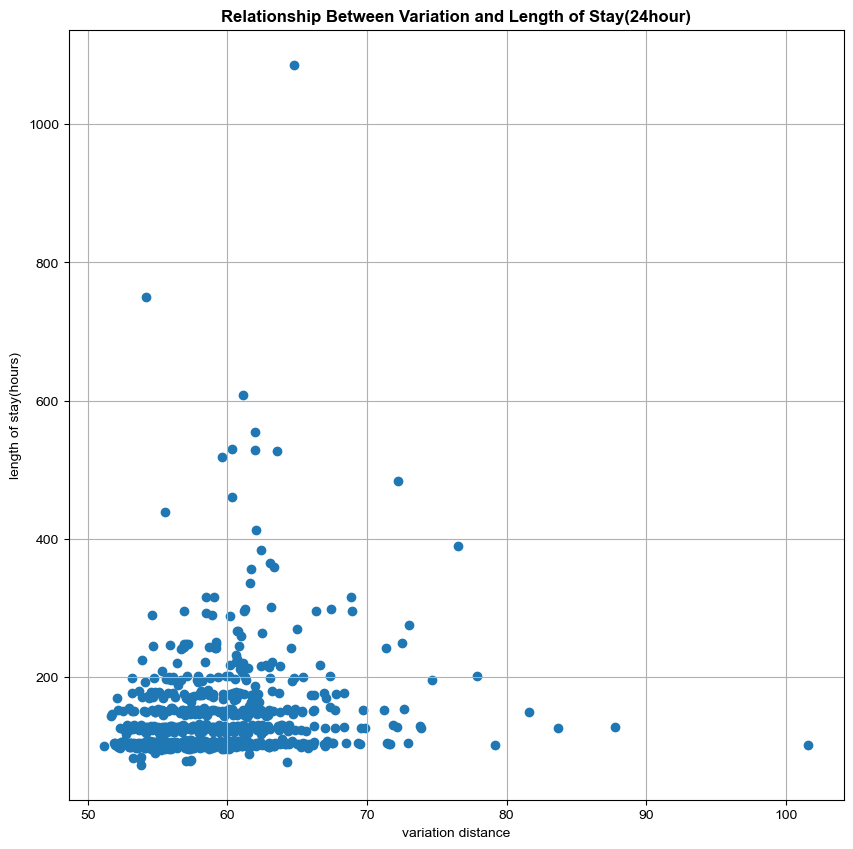

In [57]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(complete_patients['variation distance'],complete_patients['length_of_stay'])

#plt.title('Relationship Between Variation and Length of Stay(24hour)', fontsize=12, fontweight='bold')
plt.xlabel('variation distance', fontsize=10)
plt.ylabel('length of stay(hours)', fontsize=10)
plt.savefig('Figure_Relationship Between Variation and Length of Stay(24hour).png', bbox_inches='tight',format='png', dpi=800)
plt.grid(True)
plt.show()

In [30]:
#print(complete_patients.dtypes)
complete_patients['distance'] = pd.to_numeric(complete_patients['variation distance'], errors='coerce')

In [31]:
complete_patients['age_group'] = pd.cut(complete_patients['age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100],
                         labels=['20-30', '31-40', '41-50', '51-60', '61-70','71-80','81-90','91-100'])

In [32]:
def categorize_cci(cci):
    if 10 <= cci <= 12:
        return '10-12'
    elif 8 <= cci < 10:
        return '8-10'
    elif 6 <= cci < 8:
        return '6-8'
    elif 4 <= cci < 6:  
        return '4-6'
    elif 2 <= cci < 4:  
        return '2-4'
    elif 0 <= cci < 2:
        return '0-2'
complete_patients['cci_group'] = complete_patients['cci'].apply(categorize_cci)

In [33]:
'''
def categorize_distance(distance):
    if distance >= 71:
        return 'top2.5%'
    elif distance >= 67:
        return 'top5%'
    elif distance >= 64:
        return 'top10%'
    elif distance >= 61:  
        return 'top20%'
    elif 55 < distance < 61:  
        return 'middle value'
    elif distance <= 55:  
        return 'bottom20%'
'''
def categorize_distance(distance):
    if distance >= 61:  
        return 'top20%'
    else:  
        return 'Other'
complete_patients['distance_group'] = complete_patients['distance'].apply(categorize_distance)

In [34]:
print(complete_patients.head())
#complete_patients.to_csv('test.csv',index = False)
value_counts = complete_patients['distance_group'].value_counts()
print(value_counts)

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  aids  \
0         SINGLE                   1                         1  ...     0   
1        MARRIED                   0                         0  ...     0   
2        MARRIED                   0                         0  ...     0   
3        MARRIED                   0                         0  ...     0   
4        MARRIED                   1                         0  ...     0   

   cci  in_hospital_mortality  died_within_30_days  length_of_stay  

In [35]:
complete_patients['race'] = complete_patients['race'].str.split(' ').str[0]
complete_patients['race']= complete_patients['race'].replace(['BLACK/AFRICAN', 'BLACK/CARIBBEAN','BLACK/CAPE','HISPANIC/LATINO','HISPANIC','PATIENT', 'UNABLE','SOUTH','PORTUGUESE','MULTIPLE','OTHER','ASIAN','UNKNOWN'], 'OTHER')
value_counts_race = complete_patients['race'].value_counts()
print(value_counts_race)

race
WHITE    667
OTHER    180
Name: count, dtype: int64


In [36]:
value_counts_gender = complete_patients['gender'].value_counts()
print(value_counts_gender)
value_counts_insurance = complete_patients['insurance'].value_counts()
print(value_counts_insurance)

gender
M    701
F    146
Name: count, dtype: int64
insurance
Other       506
Medicare    313
Medicaid     28
Name: count, dtype: int64


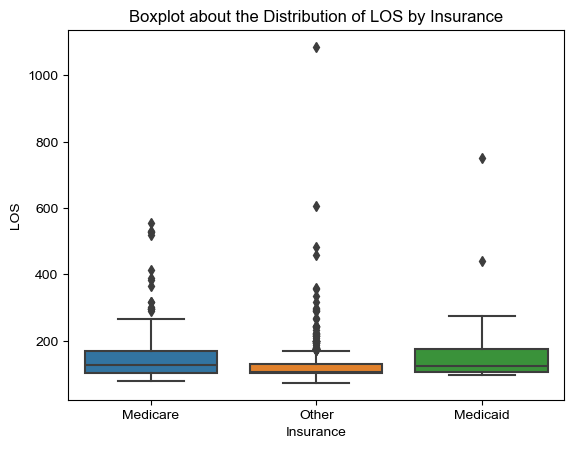

In [37]:
sns.boxplot(x='insurance', y='length_of_stay', data=complete_patients[['insurance','length_of_stay']])
plt.title('Boxplot about the Distribution of LOS by Insurance')
plt.xlabel('Insurance')
plt.ylabel('LOS')
plt.show()

In [38]:
import statsmodels.formula.api as smf

y = complete_patients['length_of_stay']
model = smf.ols('y ~ distance_group + age + cci + C(gender) + C(insurance) + C(race)', data=complete_patients).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     17.49
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           1.02e-21
Time:                        16:34:21   Log-Likelihood:                -4777.0
No. Observations:                 847   AIC:                             9570.
Df Residuals:                     839   BIC:                             9608.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [39]:
print(complete_patients.columns)

Index(['subject_id', 'hadm_id', 'age', 'gender', 'insurance', 'language',
       'race', 'marital_status', 'myocardial_infarct',
       'congestive_heart_failure', 'peripheral_vascular_disease',
       'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
       'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
       'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
       'renal_disease', 'malignant_cancer', 'severe_liver_disease',
       'metastatic_solid_tumor', 'aids', 'cci', 'in_hospital_mortality',
       'died_within_30_days', 'length_of_stay', 'variation distance',
       'distance', 'age_group', 'cci_group', 'distance_group'],
      dtype='object')


In [40]:
top_2_percent = complete_patients.loc[top_2_percent_index]
print(top_2_percent)
output_path = 'top_2_percent.csv'
top_2_percent.to_csv(output_path, index=False)
top_2_percent_los = top_2_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_2_percent_los}")
top_2_percent_in_hospital_mortality = top_2_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_2_percent_in_hospital_mortality}")
top_2_percent_30_day_mortality = top_2_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_2_percent_30_day_mortality}")
top_2_percent_cci =top_2_percent['cci'].mean()
print(f"The average of CCI is: {top_2_percent_cci}")
top_2_percent_top3cci_averages = top_2_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_2_percent_top3cci = top_2_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_2_percent_top3cci)

     subject_id   hadm_id  age gender insurance language   race  \
416    15156174  27191368   51      M     Other  ENGLISH  WHITE   
333    14195255  27013153   74      M  Medicare  ENGLISH  WHITE   
79     11047016  22671173   75      M  Medicare  ENGLISH  WHITE   
276    13651772  29738334   60      M  Medicare        ?  WHITE   
214    12782295  28711743   62      M     Other  ENGLISH  WHITE   
440    15417736  23735688   62      F  Medicare  ENGLISH  OTHER   
460    15610823  26657269   69      F  Medicare  ENGLISH  WHITE   
367    14623728  25322680   84      M  Medicare  ENGLISH  WHITE   
804    19559236  28407617   65      M     Other  ENGLISH  OTHER   
480    15837207  24785909   74      M  Medicare  ENGLISH  WHITE   
373    14728004  22631731   81      F  Medicaid        ?  OTHER   
592    16990467  29201876   60      M     Other  ENGLISH  OTHER   
123    11670352  26307293   70      M  Medicare  ENGLISH  WHITE   
80     11076206  20326682   63      F  Medicare  ENGLISH  WHIT

In [41]:
# Display the top 5% lists
print("Top 5% lists:")
print(top_5_percent_lists)

# Display the bottom 5% lists
print("Bottom 5% lists:")
print(bottom_5_percent_lists)

top_5_percent_index = top_5_percent_lists.index.tolist()
print("PatientID of Top 5% traces:")
print(top_5_percent_lists.index.tolist())
bottom_5_percent_index = bottom_5_percent_lists.index.tolist()
print("PatientID of Bottom 5% traces:")
print(bottom_5_percent_lists.index.tolist())

Top 5% lists:
    0    1   2    3    4   5   6    7    8    9    ... 837  838 839 840  841  \
416  96  100  98  101  103  96  96  100  101  105  ...  96  100  97  99  118   
333  82   87  82   81   87  79  84   83   84   88  ...  81   89  83  85  108   
79   83   81  78   81   86  74  83   80   81   83  ...  85   80  77  86   96   
276  78   82  81   83   77  76  86   77   77   83  ...  78   82  82  74   98   
214  79   72  68   75   76  78  79   77   76   77  ...  76   81  76  77   93   
440  74   75  73   77   75  78  78   75   75   72  ...  71   76  76  66   98   
460  70   74  74   73   80  67  70   69   71   72  ...  73   75  67  79   95   
367  72   73  73   72   72  70  71   74   73   74  ...  74   75  70  82   85   
804  67   68  67   66   76  73  70   67   70   73  ...  67   73  71  75   91   
480  64   70  67   66   72  70  69   69   69   69  ...  69   76  64  75   93   
373  78   71  71   73   68  79  79   69   68   71  ...  75   65  77  67   88   
592  71   76  71   73   69

In [42]:
# Display the top 10% lists
print("Top 10% lists:")
print(top_10_percent_lists)

# Display the bottom 10% lists
print("Bottom 10% lists:")
print(bottom_10_percent_lists)

top_10_percent_index = top_10_percent_lists.index.tolist()
print("PatientID of Top 10% traces:")
print(top_10_percent_lists.index.tolist())
bottom_10_percent_index = bottom_10_percent_lists.index.tolist()
print("PatientID of Bottom 10% traces:")
print(bottom_10_percent_lists.index.tolist())

Top 10% lists:
    0    1   2    3    4   5   6    7    8    9    ... 837  838 839 840  841  \
416  96  100  98  101  103  96  96  100  101  105  ...  96  100  97  99  118   
333  82   87  82   81   87  79  84   83   84   88  ...  81   89  83  85  108   
79   83   81  78   81   86  74  83   80   81   83  ...  85   80  77  86   96   
276  78   82  81   83   77  76  86   77   77   83  ...  78   82  82  74   98   
214  79   72  68   75   76  78  79   77   76   77  ...  76   81  76  77   93   
..   ..  ...  ..  ...  ...  ..  ..  ...  ...  ...  ...  ..  ...  ..  ..  ...   
462  65   66  62   66   61  68  71   59   58   59  ...  63   58  64  57   74   
596  64   62  59   64   55  71  69   56   59   59  ...  66   60  64  63   78   
99   61   65  59   59   60  65  62   58   61   58  ...  63   60  58  66   76   
787  62   64  53   53   62  66  63   60   60   56  ...  58   63  60  62   78   
70   58   66  62   59   66  59  59   58   59   60  ...  65   63  55  65   72   

     842 843  844  845  

In [43]:
# Display the top 20% lists
print("Top 20% lists:")
print(top_20_percent_lists)

# Display the bottom 20% lists
print("Bottom 20% lists:")
print(bottom_20_percent_lists)

top_20_percent_index = top_20_percent_lists.index.tolist()
print("PatientID of Top 20% traces:")
print(top_20_percent_lists.index.tolist())
bottom_20_percent_index = bottom_20_percent_lists.index.tolist()
print("PatientID of Bottom 20% traces:")
print(bottom_20_percent_lists.index.tolist())

Top 20% lists:
    0    1   2    3    4   5   6    7    8    9    ... 837  838 839 840  841  \
416  96  100  98  101  103  96  96  100  101  105  ...  96  100  97  99  118   
333  82   87  82   81   87  79  84   83   84   88  ...  81   89  83  85  108   
79   83   81  78   81   86  74  83   80   81   83  ...  85   80  77  86   96   
276  78   82  81   83   77  76  86   77   77   83  ...  78   82  82  74   98   
214  79   72  68   75   76  78  79   77   76   77  ...  76   81  76  77   93   
..   ..  ...  ..  ...  ...  ..  ..  ...  ...  ...  ...  ..  ...  ..  ..  ...   
566  59   59  54   57   53  63  66   60   56   58  ...  56   59  57  50   75   
574  72   70  66   61   60  68  72   60   54   52  ...  72   56  57  71   13   
45   62   53  56   58   63  51  60   55   56   57  ...  57   62  53  56   71   
652  60   55  56   54   63  56  61   55   55   58  ...  57   61  54  58   71   
803  63   59  58   56   59  58  65   59   55   58  ...  57   58  62  62   72   

     842 843  844  845  

In [44]:
top_5_percent = complete_patients.loc[top_5_percent_index]
output_path = 'top_5_percent.csv'
top_5_percent.to_csv(output_path, index=False)
top_5_percent_los = top_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_5_percent_los}")
top_5_percent_in_hospital_mortality = top_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_5_percent_in_hospital_mortality}")
top_5_percent_30_day_mortality = top_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_5_percent_30_day_mortality}")
top_5_percent_cci =top_5_percent['cci'].mean()
print(f"The average of CCI is: {top_5_percent_cci}")
top_5_percent_top3cci_averages = top_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_5_percent_top3cci = top_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_5_percent_top3cci)

The average of LOS is: 168.20310077519378
The average of in_hospital_mortality is: 0.023255813953488372
The average of 30_day_mortality is: 0.023255813953488372
The average of CCI is: 4.325581395348837
Top3 CCI:
myocardial_infarct           0.279070
renal_disease                0.279070
chronic_pulmonary_disease    0.255814
dtype: float64


In [45]:
top_10_percent = complete_patients.loc[top_10_percent_index]
output_path = 'top_10_percent.csv'
top_10_percent.to_csv(output_path, index=False)
top_10_percent_los = top_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_10_percent_los}")
top_10_percent_in_hospital_mortality = top_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_10_percent_in_hospital_mortality}")
top_10_percent_30_day_mortality = top_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_10_percent_30_day_mortality}")
top_10_percent_cci =top_10_percent['cci'].mean()
print(f"The average of CCI is: {top_10_percent_cci}")
top_10_percent_top3cci_averages = top_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_10_percent_top3cci = top_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_10_percent_top3cci)

The average of LOS is: 166.2721568627451
The average of in_hospital_mortality is: 0.023529411764705882
The average of 30_day_mortality is: 0.023529411764705882
The average of CCI is: 4.352941176470588
Top3 CCI:
diabetes_without_cc          0.352941
myocardial_infarct           0.282353
chronic_pulmonary_disease    0.235294
dtype: float64


In [46]:
top_20_percent = complete_patients.loc[top_20_percent_index]
output_path = 'top_20_percent.csv'
top_20_percent.to_csv(output_path, index=False)
top_20_percent_los = top_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_20_percent_los}")
top_20_percent_in_hospital_mortality = top_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_20_percent_in_hospital_mortality}")
top_20_percent_30_day_mortality = top_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_20_percent_30_day_mortality}")
top_20_percent_cci =top_20_percent['cci'].mean()
print(f"The average of CCI is: {top_20_percent_cci}")
top_20_percent_top3cci_averages = top_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_20_percent_top3cci = top_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_20_percent_top3cci)

The average of LOS is: 164.51598039215688
The average of in_hospital_mortality is: 0.01764705882352941
The average of 30_day_mortality is: 0.023529411764705882
The average of CCI is: 4.176470588235294
Top3 CCI:
diabetes_without_cc    0.382353
myocardial_infarct     0.294118
renal_disease          0.200000
dtype: float64


In [47]:
bottom_5_percent = complete_patients.loc[bottom_5_percent_index]
output_path = 'bottom_5_percent.csv'
bottom_5_percent.to_csv(output_path, index=False)
bottom_5_percent_los = bottom_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_5_percent_los}")
bottom_5_percent_in_hospital_mortality = bottom_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_5_percent_in_hospital_mortality}")
bottom_5_percent_30_day_mortality = bottom_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_5_percent_30_day_mortality}")
bottom_5_percent_cci =bottom_5_percent['cci'].mean()
print(f"The average of CCI is: {bottom_5_percent_cci}")

bottom_5_percent_top3cci_averages = bottom_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_5_percent_top3cci = bottom_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_5_percent_top3cci)

The average of LOS is: 119.50736434108526
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 3.0
Top3 CCI:
diabetes_without_cc            0.302326
myocardial_infarct             0.116279
peripheral_vascular_disease    0.093023
dtype: float64


In [48]:
bottom_10_percent = complete_patients.loc[bottom_10_percent_index]
output_path = 'bottom_10_percent.csv'
bottom_10_percent.to_csv(output_path, index=False)
bottom_10_percent_los = bottom_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_10_percent_los}")
bottom_10_percent_in_hospital_mortality = bottom_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_10_percent_in_hospital_mortality}")
bottom_10_percent_30_day_mortality = bottom_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_10_percent_30_day_mortality}")
bottom_10_percent_cci =bottom_10_percent['cci'].mean()
print(f"The average of CCI is: {bottom_10_percent_cci}")

bottom_10_percent_top3cci_averages = bottom_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_10_percent_top3cci = bottom_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_10_percent_top3cci)

The average of LOS is: 118.16058823529411
The average of in_hospital_mortality is: 0.011764705882352941
The average of 30_day_mortality is: 0.011764705882352941
The average of CCI is: 2.988235294117647
Top3 CCI:
diabetes_without_cc            0.305882
myocardial_infarct             0.141176
peripheral_vascular_disease    0.105882
dtype: float64


In [49]:
bottom_20_percent = complete_patients.loc[bottom_20_percent_index]
output_path = 'bottom_20_percent.csv'
bottom_20_percent.to_csv(output_path, index=False)
bottom_20_percent_los = bottom_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_20_percent_los}")
bottom_20_percent_in_hospital_mortality = bottom_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_20_percent_in_hospital_mortality}")
bottom_20_percent_30_day_mortality = bottom_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_20_percent_30_day_mortality}")
bottom_20_percent_cci =bottom_20_percent['cci'].mean()
print(f"The average of CCI is: {bottom_20_percent_cci}")

bottom_20_percent_top3cci_averages = bottom_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_20_percent_top3cci = bottom_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_20_percent_top3cci)

The average of LOS is: 123.15107843137255
The average of in_hospital_mortality is: 0.0058823529411764705
The average of 30_day_mortality is: 0.0058823529411764705
The average of CCI is: 3.1058823529411765
Top3 CCI:
diabetes_without_cc          0.300000
myocardial_infarct           0.194118
chronic_pulmonary_disease    0.117647
dtype: float64


In [50]:
#X = complete_patients[['age','cci','myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']]

In [51]:
traces_top_2_percent = traces.iloc[top_2_percent_index]
top_2_percent_patient = traces_top_2_percent['patientid']
print(top_2_percent_patient)
events_final_top_2_percent = events_final[events_final['patientid'].isin(top_2_percent_patient)]
print(events_final_top_2_percent)
events_final_top_2_percent.to_csv('events_final_top_2_percent.csv', index=False)

416    15156174
333    14195255
79     11047016
276    13651772
214    12782295
440    15417736
460    15610823
367    14623728
804    19559236
480    15837207
373    14728004
592    16990467
123    11670352
80     11076206
384    14795403
645    17641873
796    19514121
655    17747282
799    19522143
546    16570991
271    13616324
558    16688809
Name: patientid, dtype: int64
       patientid            events           starttime
5687    11047016             CSURG 2179-10-25 05:24:30
5688    11047016  Milk of Magnesia 2179-10-25 10:00:00
5689    11047016           Aspirin 2179-10-25 10:00:00
5690    11047016               CBC 2179-10-25 10:22:00
5691    11047016               ABG 2179-10-25 10:22:00
...          ...               ...                 ...
56417   19559236               CBC 2115-06-28 02:47:00
56418   19559236     Urea Nitrogen 2115-06-28 02:47:00
56419   19559236      Electrolytes 2115-06-28 02:47:00
56420   19559236           Glucose 2115-06-28 02:47:00
56421   19559

In [52]:
traces_top_5_percent = traces.iloc[top_5_percent_index]
top_5_percent_patient = traces_top_5_percent['patientid']
print(top_5_percent_patient)
events_final_top_5_percent = events_final[events_final['patientid'].isin(top_5_percent_patient)]
print(events_final_top_5_percent)
events_final_top_5_percent.to_csv('events_final_top_5_percent.csv', index=False)

416    15156174
333    14195255
79     11047016
276    13651772
214    12782295
440    15417736
460    15610823
367    14623728
804    19559236
480    15837207
373    14728004
592    16990467
123    11670352
80     11076206
384    14795403
645    17641873
796    19514121
655    17747282
799    19522143
546    16570991
271    13616324
558    16688809
94     11162509
517    16210214
299    13963514
184    12445879
228    12949905
13     10150912
651    17672672
759    19078583
393    14877104
806    19601036
775    19302735
117    11484011
776    19311354
200    12652551
361    14560728
685    18083865
816    19674244
309    14015770
467    15708357
353    14446098
91     11125397
Name: patientid, dtype: int64
       patientid         events           starttime
938     10150912          CSURG 2153-03-17 04:07:04
939     10150912            ABG 2153-03-17 08:59:00
940     10150912            CBC 2153-03-17 08:59:00
941     10150912        Glucose 2153-03-17 08:59:00
942     10150912      

In [53]:
traces_bottom_20_percent = traces.iloc[bottom_20_percent_index]
bottom_20_percent_patient = traces_bottom_20_percent['patientid']
print(bottom_20_percent_patient)
events_final_bottom_20_percent = events_final[events_final['patientid'].isin(bottom_20_percent_patient)]
print(events_final_bottom_20_percent)
events_final_bottom_20_percent.to_csv('events_final_bottom_20_percent.csv', index=False)

260    13405772
698    18244972
274    13635342
275    13635765
348    14352334
         ...   
690    18149759
749    18948626
8      10063488
250    13265318
734    18716421
Name: patientid, Length: 170, dtype: int64
       patientid                                    events           starttime
233     10033786                                     CSURG 2118-01-16 06:35:16
234     10033786                                       ABG 2118-01-16 12:00:00
235     10033786                                   Calcium 2118-01-16 12:00:00
236     10033786                                   Glucose 2118-01-16 12:00:00
237     10033786                                       CBC 2118-01-16 12:00:00
...          ...                                       ...                 ...
59156   19995790  Chlorhexidine Gluconate 0.12% Oral Rinse 2185-02-02 20:00:00
59157   19995790                                Ranitidine 2185-02-02 20:00:00
59158   19995790                           Docusate Sodium 2185-02-02 